## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
# https://drive.google.com/file/d/1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0/view?usp=drive_link
!gdown 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0

Downloading...
From (original): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0
From (redirected): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0&confirm=t&uuid=e2e501ab-0c34-4414-8ade-ab049436e2ab
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:07<00:00, 79.8MB/s]


In [ ]:
!unzip img_cls_weather_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: weather-dataset/dataset/frost/3922.jpg  
  inflating: weather-dataset/dataset/frost/3923.jpg  
  inflating: weather-dataset/dataset/frost/3924.jpg  
  inflating: weather-dataset/dataset/frost/3925.jpg  
  inflating: weather-dataset/dataset/frost/3926.jpg  
  inflating: weather-dataset/dataset/frost/3927.jpg  
  inflating: weather-dataset/dataset/frost/3928.jpg  
  inflating: weather-dataset/dataset/frost/3929.jpg  
  inflating: weather-dataset/dataset/frost/3930.jpg  
  inflating: weather-dataset/dataset/frost/3931.jpg  
  inflating: weather-dataset/dataset/frost/3932.jpg  
  inflating: weather-dataset/dataset/frost/3933.jpg  
  inflating: weather-dataset/dataset/frost/3934.jpg  
  inflating: weather-dataset/dataset/frost/3935.jpg  
  inflating: weather-dataset/dataset/frost/3936.jpg  
  inflating: weather-dataset/dataset/frost/3937.jpg  
  inflating: weather-dataset/dataset/frost/3938.jpg  
  inflating: weather-dataset/da

## **1. Import libraries**

In [ ]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## **2. Read dataset**

In [ ]:
root_dir = 'weather-dataset/dataset'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

## **3. Train, val, test split**

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

## **4. Create pytorch dataset**

In [ ]:
class WeatherDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

## **5. Create data preprocessing function**

In [ ]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img

## **6. Create dataloader**

In [ ]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [ ]:
train_batch_size = 256
test_batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([256, 3, 224, 224])
Labels batch shape: torch.Size([256])


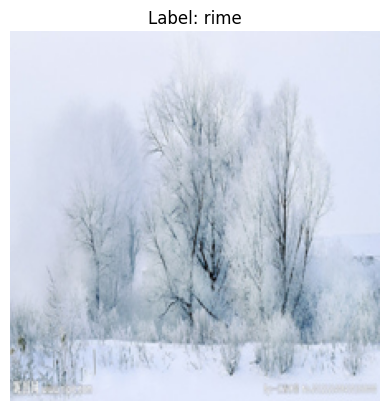

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

In [ ]:
classes

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

## **7. Create model**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1
        )
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1
        )
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)

        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride=1)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)

        return block_sequential


    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)

        flattened_conv_output = self.flatten(x)
        x = self.fc1(flattened_conv_output)

        return x, flattened_conv_output


In [ ]:
# https://drive.google.com/file/d/1DeHv1GD3qT2DgtlRVkDh01aRillGrP35/view?usp=sharing

### Uncomment the below code to download the teacher model (in case you forgot or lost the file model.pt)
!gdown 1DeHv1GD3qT2DgtlRVkDh01aRillGrP35

Downloading...
From (original): https://drive.google.com/uc?id=1DeHv1GD3qT2DgtlRVkDh01aRillGrP35
From (redirected): https://drive.google.com/uc?id=1DeHv1GD3qT2DgtlRVkDh01aRillGrP35&confirm=t&uuid=7ff7794c-0938-45ad-8337-a88477a15af8
To: /content/teacher_wt.pt
100% 85.3M/85.3M [00:01<00:00, 49.1MB/s]


In [ ]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

teacher_model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[3, 4, 6, 3],
    n_classes=n_classes
).to(device)

teacher_model.load_state_dict(
    torch.load(
        'teacher_wt.pt',
        map_location=device
    )
)

student_model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

<ipython-input-16-7dcc291ab66a>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


In [ ]:
teacher_model.eval()
student_model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    teacher_output = teacher_model(dummy_tensor)
    student_output = student_model(dummy_tensor)

print('Teacher output shape:', teacher_output[0].shape, teacher_output[1].shape)
print('Student output shape:', student_output[0].shape, student_output[1].shape)

Teacher output shape: torch.Size([1, 11]) torch.Size([1, 512])
Student output shape: torch.Size([1, 11]) torch.Size([1, 512])


## **8. Training**

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [ ]:
def fit(
    teacher,
    student,
    T,
    hidden_rep_loss_weight,
    ce_loss_weight,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []
    val_accs = []
    teacher.eval()

    cosine_loss = nn.CosineEmbeddingLoss()

    for epoch in range(epochs):
        batch_train_losses = []

        student.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                _, teacher_hidden_representation = teacher(inputs)
            student_logits, student_hidden_representation = student(inputs)

            hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(inputs.size(0)).to(device))

            label_loss = criterion(student_logits, labels)

            loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            student, val_loader,
            criterion, device
        )
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        scheduler.step()

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal acc: {val_acc:.4f}')

    return train_losses, val_losses, val_accs

In [ ]:
lr = 1e-2
epochs = 30

def lr_lambda(epoch, warmup_epochs=5, total_epochs=30, init_scale=0.1, min_scale=0.3):
    scale_range = 1.0 - min_scale

    if epoch < warmup_epochs:
        warmup_factor = epoch / warmup_epochs
        return init_scale + (1.0 - init_scale) * warmup_factor

    decay_factor = (total_epochs - epoch) / (total_epochs - warmup_epochs)
    return min_scale + scale_range * max(0.0, decay_factor)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    student_model.parameters(),
    lr=lr
)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [ ]:
for epoch in range(epochs):
    print(f'Epoch {epoch}, LR: {lr * lr_lambda(epoch):.6f}')

Epoch 0, LR: 0.001000
Epoch 1, LR: 0.002800
Epoch 2, LR: 0.004600
Epoch 3, LR: 0.006400
Epoch 4, LR: 0.008200
Epoch 5, LR: 0.010000
Epoch 6, LR: 0.009720
Epoch 7, LR: 0.009440
Epoch 8, LR: 0.009160
Epoch 9, LR: 0.008880
Epoch 10, LR: 0.008600
Epoch 11, LR: 0.008320
Epoch 12, LR: 0.008040
Epoch 13, LR: 0.007760
Epoch 14, LR: 0.007480
Epoch 15, LR: 0.007200
Epoch 16, LR: 0.006920
Epoch 17, LR: 0.006640
Epoch 18, LR: 0.006360
Epoch 19, LR: 0.006080
Epoch 20, LR: 0.005800
Epoch 21, LR: 0.005520
Epoch 22, LR: 0.005240
Epoch 23, LR: 0.004960
Epoch 24, LR: 0.004680
Epoch 25, LR: 0.004400
Epoch 26, LR: 0.004120
Epoch 27, LR: 0.003840
Epoch 28, LR: 0.003560
Epoch 29, LR: 0.003280


In [ ]:
train_losses, val_losses, val_accs = fit(
    teacher_model,
    student_model,
    2,
    0.25,
    0.75,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.8067	Val loss: 2.3772	Val acc: 0.1122
EPOCH 2:	Train loss: 1.5045	Val loss: 2.2126	Val acc: 0.2083
EPOCH 3:	Train loss: 1.2358	Val loss: 1.7522	Val acc: 0.4341
EPOCH 4:	Train loss: 1.0843	Val loss: 1.6695	Val acc: 0.4545
EPOCH 5:	Train loss: 0.9975	Val loss: 1.2696	Val acc: 0.5768
EPOCH 6:	Train loss: 0.9140	Val loss: 1.3048	Val acc: 0.5652
EPOCH 7:	Train loss: 0.8387	Val loss: 1.5110	Val acc: 0.5113
EPOCH 8:	Train loss: 0.7900	Val loss: 1.1464	Val acc: 0.6169
EPOCH 9:	Train loss: 0.7545	Val loss: 1.1530	Val acc: 0.6089
EPOCH 10:	Train loss: 0.7143	Val loss: 1.0194	Val acc: 0.6693
EPOCH 11:	Train loss: 0.6940	Val loss: 1.0398	Val acc: 0.6475
EPOCH 12:	Train loss: 0.6514	Val loss: 1.6188	Val acc: 0.4807
EPOCH 13:	Train loss: 0.6145	Val loss: 0.9763	Val acc: 0.6744
EPOCH 14:	Train loss: 0.5908	Val loss: 1.0468	Val acc: 0.6482
EPOCH 15:	Train loss: 0.5609	Val loss: 1.2671	Val acc: 0.6074
EPOCH 16:	Train loss: 0.5485	Val loss: 0.9315	Val acc: 0.6766
EPOCH 17:	Train l

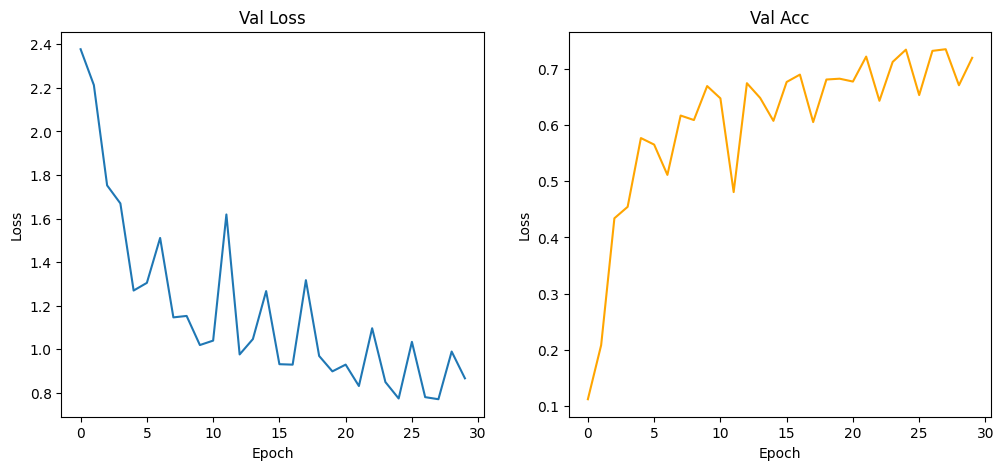

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(val_losses)
ax[0].set_title('Val Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_accs, color='orange')
ax[1].set_title('Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## **9. Evaluation**

In [ ]:
val_loss, val_acc = evaluate(
    student_model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    student_model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.71959213401311
Test accuracy:  0.735080058224163


## **10. Download the model**

In [ ]:
save_path = '/content/cosine_samedata_wt.pt'
torch.save(student_model.state_dict(), save_path)